In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import vision_transformer
from torch.utils.data import DataLoader
import ssl

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ssl._create_default_https_context = ssl._create_unverified_context
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
dataset = torchvision.datasets.EuroSAT(root="", download = True, transform = transform)

100%|██████████| 94280567/94280567 [00:05<00:00, 16666242.09it/s]


Extracting eurosat/EuroSAT.zip to eurosat


In [3]:
ratio = 0.85                                                                                    # Train test split
train_samp = int(ratio * len(dataset))
test_samp = len(dataset) - train_samp
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_samp, test_samp])


**Making the dataloaders for the train and test dataset**

In [4]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

## 1. Fine tuning the final layer

Making all the layers except the final layer as non trainable

In [5]:
model = vision_transformer.vit_b_32(pretrained=True)
model.heads.head = nn.Linear(in_features=768,out_features=10,bias=True)

for param in model.parameters():
    param.requires_grad = False
for param in model.heads.head.parameters():
    param.requires_grad = True

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth
100%|██████████| 337M/337M [00:02<00:00, 164MB/s]


In [6]:
model = model

In [7]:
for name, param in model.named_parameters():
  print(name, param.requires_grad)

class_token False
conv_proj.weight False
conv_proj.bias False
encoder.pos_embedding False
encoder.layers.encoder_layer_0.ln_1.weight False
encoder.layers.encoder_layer_0.ln_1.bias False
encoder.layers.encoder_layer_0.self_attention.in_proj_weight False
encoder.layers.encoder_layer_0.self_attention.in_proj_bias False
encoder.layers.encoder_layer_0.self_attention.out_proj.weight False
encoder.layers.encoder_layer_0.self_attention.out_proj.bias False
encoder.layers.encoder_layer_0.ln_2.weight False
encoder.layers.encoder_layer_0.ln_2.bias False
encoder.layers.encoder_layer_0.mlp.0.weight False
encoder.layers.encoder_layer_0.mlp.0.bias False
encoder.layers.encoder_layer_0.mlp.3.weight False
encoder.layers.encoder_layer_0.mlp.3.bias False
encoder.layers.encoder_layer_1.ln_1.weight False
encoder.layers.encoder_layer_1.ln_1.bias False
encoder.layers.encoder_layer_1.self_attention.in_proj_weight False
encoder.layers.encoder_layer_1.self_attention.in_proj_bias False
encoder.layers.encoder_layer

**We can observe that only the final layer in the above model is trainable**

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [9]:
model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

**Defining the activation function**

In [13]:
import matplotlib.pyplot as plt

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [10]:
for epoch in range(2):
    # Training the model
    model.train()
    for images, labels in train_loader:  # Iterate through DataLoader
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epochs [{epoch + 1}/{2}]')
    print(f'Training Loss: {loss.item():.4f}')

Epochs [1/2]
Training Loss: 0.0701
Epochs [2/2]
Training Loss: 0.0298


In [11]:
# Testing
model.eval()
actual = 0
total = 0

In [12]:
with torch.no_grad():
    for images, labels in test_loader:  # Iterate through your test DataLoader
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        actual += (predicted == labels).sum().item()

# Test accuracy
test_accuracy = 100 * actual / total
print(f'Testing Accuracy: {test_accuracy:.2f}%')

Testing Accuracy: 95.63%


In [24]:
model.encoder.layers.encoder_layer_6.register_forward_hook(get_activation("1"))

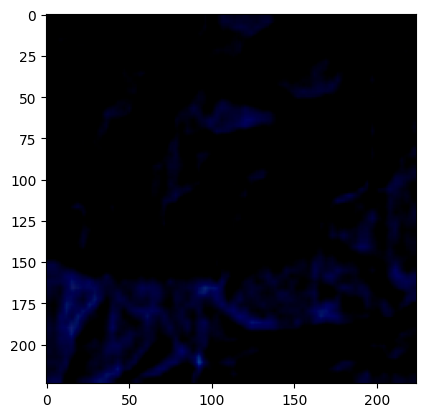

In [25]:
for i, l in test_loader:
  img1 = i
  break

plt.imshow(img1[10].cpu().detach().numpy().transpose(1,2,0))
plt.show()

In [26]:
output = model(img1[0][None,:,:,:].to(device))

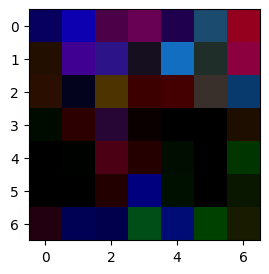

In [28]:
a = activation["1"][0,:,:][1:,:]
img = a[:, 3:6].reshape(7,7,3)
plt.figure(figsize=(3,3))
plt.imshow(img.cpu().detach().numpy())

**NOW WE WILL JUST RUN THE ABOVE CODE FOR ALL 3 OTHER CASES AFTER CHANGING THE TRAINABLE LAYERS**

## 2. Finetuning the bottom layers

In [48]:
model = vision_transformer.vit_b_16(pretrained=True)
model.heads.head = nn.Linear(in_features=768,out_features=10,bias=True)

for param in model.parameters():
    param.requires_grad = True

for param in model.heads.head.parameters():
    param.requires_grad = False

model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [49]:
for name, param in model.named_parameters():
  print(name, param.requires_grad)

class_token True
conv_proj.weight True
conv_proj.bias True
encoder.pos_embedding True
encoder.layers.encoder_layer_0.ln_1.weight True
encoder.layers.encoder_layer_0.ln_1.bias True
encoder.layers.encoder_layer_0.self_attention.in_proj_weight True
encoder.layers.encoder_layer_0.self_attention.in_proj_bias True
encoder.layers.encoder_layer_0.self_attention.out_proj.weight True
encoder.layers.encoder_layer_0.self_attention.out_proj.bias True
encoder.layers.encoder_layer_0.ln_2.weight True
encoder.layers.encoder_layer_0.ln_2.bias True
encoder.layers.encoder_layer_0.mlp.0.weight True
encoder.layers.encoder_layer_0.mlp.0.bias True
encoder.layers.encoder_layer_0.mlp.3.weight True
encoder.layers.encoder_layer_0.mlp.3.bias True
encoder.layers.encoder_layer_1.ln_1.weight True
encoder.layers.encoder_layer_1.ln_1.bias True
encoder.layers.encoder_layer_1.self_attention.in_proj_weight True
encoder.layers.encoder_layer_1.self_attention.in_proj_bias True
encoder.layers.encoder_layer_1.self_attention.ou

Epochs [1/2]
Training Loss: 2.4217
Epochs [2/2]
Training Loss: 2.2437


Testing Accuracy: 6.79%


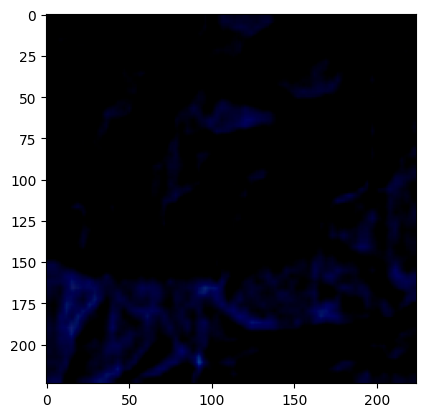

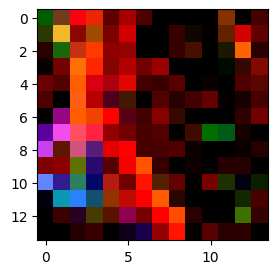

In [50]:
for epoch in range(2):
    # Training
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epochs [{epoch + 1}/{2}]')
    print(f'Training Loss: {loss.item():.4f}')

# Testing
model.eval()
actual = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        actual += (predicted == labels).sum().item()

# Test accuracy
test_accuracy = 100 * actual / total
print(f'Testing Accuracy: {test_accuracy:.2f}%')

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.encoder.layers.encoder_layer_6.register_forward_hook(get_activation("2"))
for i, l in test_loader:
  img1 = i
  break

plt.imshow(img1[10].cpu().detach().numpy().transpose(1,2,0))
plt.show()

output = model(img1[0][None,:,:,:].to(device))

a = activation["2"][0,:,:][1:,:]
img = a[:, 3:6].reshape(14,14,3)
plt.figure(figsize=(3,3))
plt.imshow(img.cpu().detach().numpy())

## 3. Full fine tune on the eurosat data

In [38]:
model = vision_transformer.vit_b_16(pretrained=True)
model.heads.head = nn.Linear(in_features=768,out_features=10,bias=True)

for param in model.parameters():
    param.requires_grad = True

model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [39]:
for name, param in model.named_parameters():
  print(name, param.requires_grad)

class_token True
conv_proj.weight True
conv_proj.bias True
encoder.pos_embedding True
encoder.layers.encoder_layer_0.ln_1.weight True
encoder.layers.encoder_layer_0.ln_1.bias True
encoder.layers.encoder_layer_0.self_attention.in_proj_weight True
encoder.layers.encoder_layer_0.self_attention.in_proj_bias True
encoder.layers.encoder_layer_0.self_attention.out_proj.weight True
encoder.layers.encoder_layer_0.self_attention.out_proj.bias True
encoder.layers.encoder_layer_0.ln_2.weight True
encoder.layers.encoder_layer_0.ln_2.bias True
encoder.layers.encoder_layer_0.mlp.0.weight True
encoder.layers.encoder_layer_0.mlp.0.bias True
encoder.layers.encoder_layer_0.mlp.3.weight True
encoder.layers.encoder_layer_0.mlp.3.bias True
encoder.layers.encoder_layer_1.ln_1.weight True
encoder.layers.encoder_layer_1.ln_1.bias True
encoder.layers.encoder_layer_1.self_attention.in_proj_weight True
encoder.layers.encoder_layer_1.self_attention.in_proj_bias True
encoder.layers.encoder_layer_1.self_attention.ou

Epochs [1/2]
Training Loss: 2.4535
Epochs [2/2]
Training Loss: 2.2607


Testing Accuracy: 6.15%


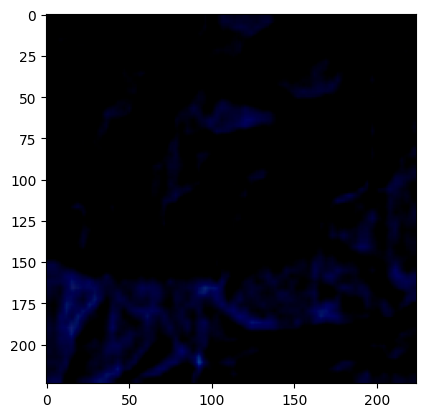

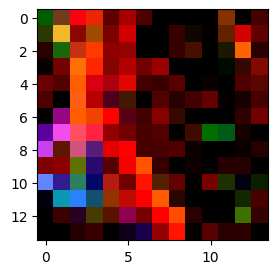

In [40]:
for epoch in range(2):
    # Training
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epochs [{epoch + 1}/{2}]')
    print(f'Training Loss: {loss.item():.4f}')

# Testing
model.eval()
actual = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        actual += (predicted == labels).sum().item()

# Test accuracy
test_accuracy = 100 * actual / total
print(f'Testing Accuracy: {test_accuracy:.2f}%')

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.encoder.layers.encoder_layer_6.register_forward_hook(get_activation("3"))
for i, l in test_loader:
  img1 = i
  break

plt.imshow(img1[10].cpu().detach().numpy().transpose(1,2,0))
plt.show()

output = model(img1[0][None,:,:,:].to(device))

a = activation["3"][0,:,:][1:,:]
img = a[:, 3:6].reshape(14,14,3)
plt.figure(figsize=(3,3))
plt.imshow(img.cpu().detach().numpy())

## 4. No fine tuning

In [44]:
model = vision_transformer.vit_b_16(pretrained=True)
model.heads.head = nn.Linear(in_features=768,out_features=10,bias=True)

for param in model.parameters():
    param.requires_grad = False
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [45]:
for name, param in model.named_parameters():
  print(name, param.requires_grad)

class_token False
conv_proj.weight False
conv_proj.bias False
encoder.pos_embedding False
encoder.layers.encoder_layer_0.ln_1.weight False
encoder.layers.encoder_layer_0.ln_1.bias False
encoder.layers.encoder_layer_0.self_attention.in_proj_weight False
encoder.layers.encoder_layer_0.self_attention.in_proj_bias False
encoder.layers.encoder_layer_0.self_attention.out_proj.weight False
encoder.layers.encoder_layer_0.self_attention.out_proj.bias False
encoder.layers.encoder_layer_0.ln_2.weight False
encoder.layers.encoder_layer_0.ln_2.bias False
encoder.layers.encoder_layer_0.mlp.0.weight False
encoder.layers.encoder_layer_0.mlp.0.bias False
encoder.layers.encoder_layer_0.mlp.3.weight False
encoder.layers.encoder_layer_0.mlp.3.bias False
encoder.layers.encoder_layer_1.ln_1.weight False
encoder.layers.encoder_layer_1.ln_1.bias False
encoder.layers.encoder_layer_1.self_attention.in_proj_weight False
encoder.layers.encoder_layer_1.self_attention.in_proj_bias False
encoder.layers.encoder_layer

Testing Accuracy: 5.73%


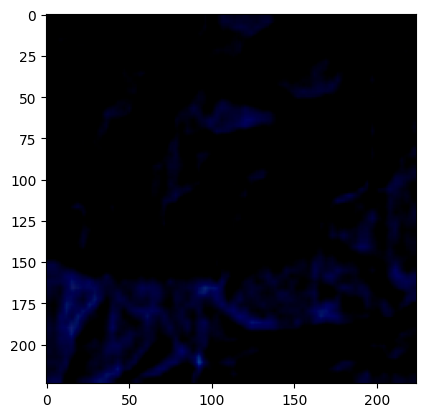

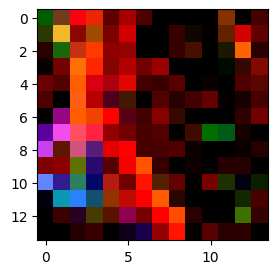

In [47]:
# Testing
model.eval()
actual = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        actual += (predicted == labels).sum().item()

# Test accuracy
test_accuracy = 100 * actual / total
print(f'Testing Accuracy: {test_accuracy:.2f}%')

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.encoder.layers.encoder_layer_6.register_forward_hook(get_activation("4"))
for i, l in test_loader:
  img1 = i
  break

plt.imshow(img1[10].cpu().detach().numpy().transpose(1,2,0))
plt.show()

output = model(img1[0][None,:,:,:].to(device))

a = activation["4"][0,:,:][1:,:]
img = a[:, 3:6].reshape(14,14,3)
plt.figure(figsize=(3,3))
plt.imshow(img.cpu().detach().numpy())